Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [13]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline


First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = './../data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Now, lets introduce regularization via L2 penalization in the cost function (Logistic Model)

In [6]:
batch_size = 128
beta=1.0 #Regularization parameter
graph_LR_SGD_REG = tf.Graph()

with graph_LR_SGD_REG.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    ## ATENTION HERE!!!
    tf_beta=tf.constant(beta)
  
    # Variables.
    weights = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
  
    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits))
            +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights)))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
def train_LR_SGD_REG(mygraph,beta,num_steps):
    
    with tf.Session(graph=mygraph) as session:
        tf.global_variables_initializer().run()
        print("Reg. parameter =%r" %(beta))
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, tf_beta: beta}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy,test_accuracy=accuracy(valid_prediction.eval(), valid_labels),accuracy(test_prediction.eval(), test_labels)
    return valid_accuracy,test_accuracy

In [8]:
num_steps = 10001
beta=np.logspace(-4, -2, 5) #Regularization parameter
print(beta)
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_LR_SGD_REG,beta[i],num_steps)

[ 0.0001      0.00031623  0.001       0.00316228  0.01      ]
Reg. parameter =0.0001
Reg. parameter =0.00031622776601683794
Reg. parameter =0.001
Reg. parameter =0.0031622776601683794
Reg. parameter =0.01


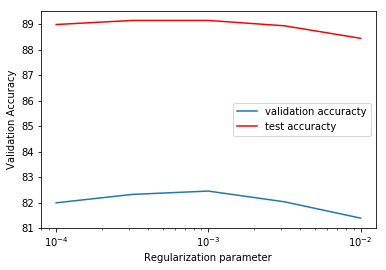

In [14]:
plt.semilogx(beta,val_performace,label='validation accuracty')
plt.semilogx(beta,test_performace,'r',label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend(loc=5)

In [15]:
print ("The best test accuracy achieved is %r" %(np.max(test_performace)))
betaCV=beta[np.argmax(val_performace)]
print (betaCV)

The best test accuracy achieved is 89.140000000000001
0.001


Now, lets introduce regularization via L2 penalization in the cost function (NN Model)

In [16]:
batch_size = 128
n_units=500
beta=1.0
graph_2NN = tf.Graph()

with graph_2NN.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    
    tf_test_dataset = tf.constant(test_dataset)
    
    tf_beta=tf.placeholder(tf.float32) 
    
    # Variables.
    # We have two weight matrices and two bias vectors
    weights_1 = tf.Variable(tf.truncated_normal([image_size * image_size, n_units]))
    biases_1 = tf.Variable(tf.zeros([n_units]))
    
    weights_2 = tf.Variable(tf.truncated_normal([n_units, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    
    hidden_1 = tf.nn.relu(logits_1)
    
    logits_2 = tf.matmul(hidden_1,weights_2) + biases_2
    
    loss=(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits_2))
        +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights_1))
        +tf_beta*tf.reduce_mean(tf.nn.l2_loss(weights_2)))
        
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)    
    
    # Validation and test computation
    logits_val_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    
    hidden_val_1 = tf.nn.relu(logits_val_1)
    
    logits_val_2 = tf.matmul(hidden_val_1,weights_2) + biases_2   

    logits_test_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    
    hidden_test_1 = tf.nn.relu(logits_test_1)
    
    logits_test_2 = tf.matmul(hidden_test_1,weights_2) + biases_2  
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits_2)
    valid_prediction = tf.nn.softmax(logits_val_2)
    test_prediction = tf.nn.softmax(logits_test_2)    
    

In [17]:
num_steps = 2000
beta=np.logspace(-4, -3, 5) #Regularization parameter
val_performace=np.zeros(beta.shape)
test_performace=np.zeros(beta.shape) 
for i in range(beta.shape[0]):
    val_performace[i], test_performace[i]=train_LR_SGD_REG(graph_2NN,beta[i],num_steps)

Reg. parameter =0.0001
Reg. parameter =0.00017782794100389227
Reg. parameter =0.00031622776601683794
Reg. parameter =0.0005623413251903491
Reg. parameter =0.001


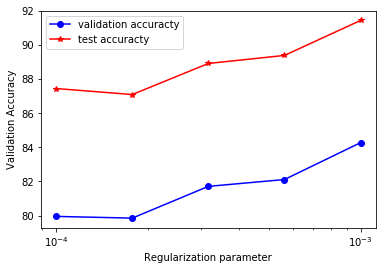

In [18]:
plt.semilogx(beta,val_performace,'-bo',label='validation accuracty')
plt.semilogx(beta,test_performace,'-r*',label='test accuracty')
plt.xlabel('Regularization parameter')
plt.ylabel('Validation Accuracy')
plt.legend()

In [19]:
print ("The best test accuracy achieved is %r" %(np.max(test_performace)))
betaCV=beta[np.argmax(val_performace)]
print (betaCV)

The best test accuracy achieved is 91.430000000000007
0.001


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
